# Instrumental variables

## IV example on mock dataset

### Constructing the dataset

Create four random series of length $N=1000$

- $x$: education
- $y$: salary
- $z$: ambition
- $q$: early smoking 

such that:

1. $x$ and $z$ cause $y$
2. $z$ causes $x$
3. $q$ is correlated with $x$, not with $z$


A problem arises when the confounding factor $z$ is not observed. In that case, we can estimate the direct effect of $x$ on $y$ by using $q$ as an instrument.

Run the follwing code to create a mock dataset.

In [2]:
import numpy as np
import pandas as pd

In [3]:
N = 100000
ϵ_z = np.random.randn(N)*0.1
ϵ_x = np.random.randn(N)*0.1
ϵ_q = np.random.randn(N)*0.01
ϵ_y = np.random.randn(N)*0.01

In [4]:
z = 0.1 + ϵ_z
q = 0.5 + 0.1234*ϵ_x + ϵ_q
# here we must change the definition so that q affects x:
# x = 0.1 + z + ϵ_x
x = 0.1 + z + q + ϵ_x
y  = 1.0 + 0.9*x + 0.4*z + ϵ_y

In [5]:
df = pd.DataFrame({
    "x": x,
    "y": y,
    "z": z,
    "q": q
})

__Describe the dataframe. Compute the correlations between the variables. Are they compatible with the hypotheses for IV?__

In [6]:
df.head()

,x,y,z,q
0,0.458958,1.428012,-0.006158,0.489963
1,0.536544,1.535235,0.119739,0.484211
2,0.550795,1.561178,0.149119,0.470899
3,0.774870,1.773310,0.184079,0.501838
4,0.761371,1.769818,0.197662,0.501622


In [7]:
df.describe()

,x,y,z,q
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.699704,1.669716,0.099930,0.499973
std,0.150261,0.164733,0.099805,0.015818
min,-0.037950,0.874772,-0.301234,0.429432
25%,0.598491,1.558824,0.032560,0.489285
50%,0.699121,1.669068,0.099462,0.499978
75%,0.800179,1.780555,0.167347,0.510695
max,1.329398,2.349659,0.522942,0.567387


In [8]:
df.corr()

,x,y,z,q
x,1.000000,0.981526,0.662762,0.618551
y,0.981526,1.000000,0.786408,0.507140
z,0.662762,0.786408,1.000000,-0.002547
q,0.618551,0.507140,-0.002547,1.000000


### OLS Regression

Use `linearmodels` to  run a regression estimating the effect of $x$ on $y$ (note the slight API change w.r.t. `statsmodels`). Comment.

In [9]:
from linearmodels import OLS, IV2SLS

In [10]:
model = OLS.from_formula("y ~ x", df)
res = model.fit()
res      # in statsmodels would be res.summary()

OLS Estimation Summary                            
==============================================================================
Dep. Variable:                      y   R-squared:                      0.9634
Estimator:                        OLS   Adj. R-squared:                 0.9634
No. Observations:              100000   F-statistic:                 2.637e+06
Date:                Wed, Feb 21 2024   P-value (F-stat)                0.0000
Time:                        15:08:54   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.9168     0.0005     1932.5     0.0000      0.9159      0.9177
x              1.0761     0.0007     1624.0     0.0000      1.0748      1.0774
==============================================================================
OLSResults, id: 0x7f79702b7c50

The regression is globally very significant (p-value < 1.e-5). The predictive power is very high (R^2=0.96).

Constants and coefficients are both statistically very significant (p-values<1e-5 for both) and the confidence intervals are very small.


__Assume briefly that `z` is known and control the regression by `z`. What happens?__

In [11]:
model = OLS.from_formula("y ~ x + z", df)
res = model.fit()
res  

OLS Estimation Summary                            
==============================================================================
Dep. Variable:                      y   R-squared:                      0.9963
Estimator:                        OLS   Adj. R-squared:                 0.9963
No. Observations:              100000   F-statistic:                 2.713e+07
Date:                Wed, Feb 21 2024   P-value (F-stat)                0.0000
Time:                        15:08:59   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.0000     0.0002     5752.0     0.0000      0.9997      1.0004
x              0.9000     0.0003     3213.3     0.0000      0.8994      0.9005
z              0.4000     0.0004     944.90     0.0000      0.3992      0.4008
==============================================================================
OLSResults, id: 0x7f79702eb020

### Instrumental variable

Make a causality graph, summarizing what you know from the equations.

Use $q$ to instrument the effect of x on y. Comment.

In [50]:
from linearmodels import IV2SLS
formula = (
    "y ~ 1 + [x~q]"   # IV2SLS has no intercept by default
)
mod = IV2SLS.from_formula(formula, df)
res = mod.fit()
res

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      y   R-squared:                      0.9389
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9389
No. Observations:              100000   F-statistic:                 4.316e+05
Date:                Wed, Feb 14 2024   P-value (F-stat)                0.0000
Time:                        11:30:43   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.0383     0.0010     1071.1     0.0000      1.0364      1.0402
x              0.9022     0.0014     656.96     0.0000      0.8995      0.9048
==============================================================================

Endogenous: x
Instruments: q
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7fcf7dd34d10

> comment

## Return on Education

We follow the excellent R [tutorial](https://www.econometrics-with-r.org/12-6-exercises-10.html) from the (excellent) *Econometrics with R* book.

The goal is to measure the effect of schooling on earnings, while correcting the endogeneity bias by using distance to college as an instrument.

__Download the college distance dataset with `statsmodels`. Describe the dataset and extract the dataframe.__

https://vincentarelbundock.github.io/Rdatasets/datasets.html

In [72]:
import statsmodels.api as sm
ds = sm.datasets.get_rdataset("CollegeDistance", "AER")

In [73]:
ds?

Type:            Dataset
String form:     <class 'statsmodels.datasets.utils.Dataset'>
Length:          5
File:            ~/.local/opt/micromamba/envs/escp/lib/python3.12/site-packages/statsmodels/datasets/utils.py
Docstring:      
.. container::

=============== ===============
CollegeDistance R Documentation
=============== ===============

.. rubric:: College Distance Data
   :name: CollegeDistance

.. rubric:: Description
   :name: description

Cross-section data from the High School and Beyond survey conducted
by the Department of Education in 1980, with a follow-up in 1986. The
survey included students from approximately 1,100 high schools.

.. rubric:: Usage
   :name: usage

.. code:: R

   data("CollegeDistance")

.. rubric:: Format
   :name: format

A data frame containing 4,739 observations on 14 variables.

gender
   factor indicating gender.

ethnicity
   factor indicating ethnicity (African-American, Hispanic or other).

score
   base year composite test score. These are 

In [74]:
# describe dataset
# print(ds.__doc__)

In [75]:
df = ds.data # dataframe attached to dataset

In [76]:
# describe dataframe

df.head()

,gender,ethnicity,score,fcollege,mcollege,home,urban,unemp,wage,distance,tuition,education,income,region
rownames,,,,,,,,,,,,,,
1,male,other,39.150002,yes,no,yes,yes,6.2,8.09,0.2,0.88915,12,high,other
2,female,other,48.869999,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
3,male,other,48.740002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
4,male,afam,40.400002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
5,female,other,40.480000,no,no,no,yes,5.6,8.09,0.4,0.88915,13,low,other


__How is `income` encoded? Create a binary variable `income_binary` to replace it.__

In [77]:
df['income'] # takes two values `high` an `low`

rownames
1       high
2        low
3        low
4        low
5        low
        ... 
9391    high
9401    high
9411    high
9421    high
9431    high
Name: income, Length: 4739, dtype: object

In [78]:
df['income'].unique()

array(['high', 'low'], dtype=object)

In [79]:
# define a binary variable `income_binary` : 0 if income is low, 1 otherwise

In [87]:
df['income_binary'] = (df['income'] == 'high')*1.0
# multiply by 1.0 to convert booleans into binary

In [88]:
df['income_binary']

rownames
1       1.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
9391    1.0
9401    1.0
9411    1.0
9421    1.0
9431    1.0
Name: income_binary, Length: 4739, dtype: float64

__Plot an histogram of distance to college.__

In [91]:
df['distance'].describe()

count    4739.000000
mean        1.802870
std         2.297128
min         0.000000
25%         0.400000
50%         1.000000
75%         2.500000
max        20.000000
Name: distance, dtype: float64

<Axes: >

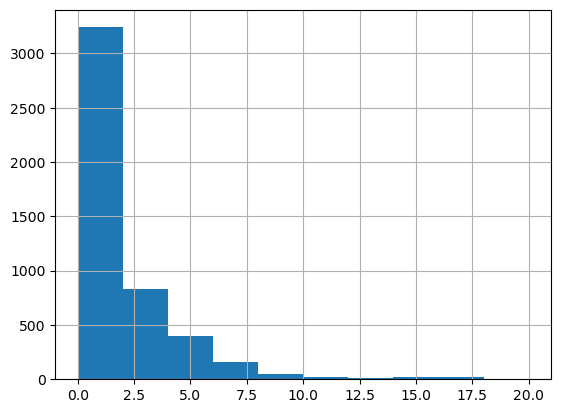

In [93]:
df['distance'].hist()

In [94]:
# other ways to do a histogram

In [97]:
from matplotlib import pyplot as plt
# plt.hist(df['distance']) # same graph

<Axes: xlabel='distance', ylabel='Count'>

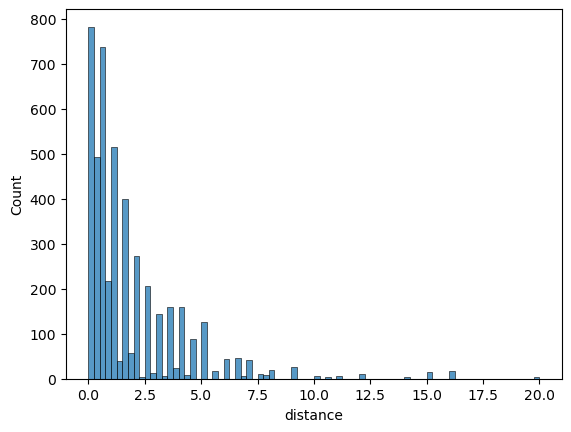

In [99]:
# use seaborn
import seaborn as sns
sns.histplot(df['distance'])

__Run the naive regression $income_{binary}=\beta_0 + \beta_1 \text{education} + u$.__



In [100]:
from linearmodels import IV2SLS
formula = (
    "income_binary ~ 1 + education"   # IV2SLS has no intercept by default
)
mod = IV2SLS.from_formula(formula, df)
res = mod.fit()
res

OLS Estimation Summary                            
==============================================================================
Dep. Variable:          income_binary   R-squared:                      0.0480
Estimator:                        OLS   Adj. R-squared:                 0.0478
No. Observations:                4739   F-statistic:                    227.43
Date:                Wed, Feb 14 2024   P-value (F-stat)                0.0000
Time:                        11:57:29   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.4780     0.0499    -9.5702     0.0000     -0.5759     -0.3801
education      0.0555     0.0037     15.081     0.0000      0.0483      0.0627
==============================================================================
OLSResults, id: 0x7fcf62b1dc40

__Augment the regression with `unemp`, `hispanic`, `af-am`, `female` and `urban`. Notice that categorical variables are encoded automatically. What are the treatment values? Change it using the syntax (`C(var,Treatment='ref')`)__

In [102]:
df.columns

Index(['gender', 'ethnicity', 'score', 'fcollege', 'mcollege', 'home', 'urban',
       'unemp', 'wage', 'distance', 'tuition', 'education', 'income', 'region',
       'income_binary'],
      dtype='object')

In [104]:
from linearmodels import IV2SLS
formula = (
    "income_binary ~ 1 + education + gender + ethnicity + urban + unemp"   # IV2SLS has no intercept by default
)
mod = IV2SLS.from_formula(formula, df)
res = mod.fit()
res

OLS Estimation Summary                            
==============================================================================
Dep. Variable:          income_binary   R-squared:                      0.0830
Estimator:                        OLS   Adj. R-squared:                 0.0818
No. Observations:                4739   F-statistic:                    456.93
Date:                Wed, Feb 14 2024   P-value (F-stat)                0.0000
Time:                        12:02:32   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                   
=========================================================================================
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
Intercept                -0.4159     0.0538    -7.7362     0.0000     -0.5212     -0.3105
education                 0.0511     0.0036     14.030     0.0000      0.0440      0.0583
gender[T.male]            0.0490     0.0128     3.8341     0.0001      0.0239      0.0740
ethnicity[T.hispanic]    -0.0296     0.0185    -1.6006     0.1095     -0.0660      0.0067
ethnicity[T.other]        0.1235     0.0167     7.3992     0.0000      0.0908      0.1563
urban[T.yes]             -0.0470     0.0149    -3.1556     0.0016     -0.0763     -0.0178
unemp                    -0.0115     0.0023    -5.0997     0.0000     -0.0159     -0.0071
=========================================================================================
OLSResults, id: 0x7fcf62a4b4d0

In [106]:
df['ethnicity'].unique()

array(['other', 'afam', 'hispanic'], dtype=object)

The library has created automatically dummy variable for categories.
For the `ethnicity` variable, it has used `afam` as reference value.
Let's use `other` as reference value.

In [ ]:
#

# C(ethnicity) -> flags ethnicity as categorical variable
$ C(ethnicity, Treatment(reference='other'))

In [107]:
from linearmodels import IV2SLS
formula = (
    "income_binary ~ 1 + education + gender + C(ethnicity, Treatment(reference='other')) + urban + unemp"   # IV2SLS has no intercept by default
)
mod = IV2SLS.from_formula(formula, df)
res = mod.fit()
res

OLS Estimation Summary                            
==============================================================================
Dep. Variable:          income_binary   R-squared:                      0.0830
Estimator:                        OLS   Adj. R-squared:                 0.0818
No. Observations:                4739   F-statistic:                    456.93
Date:                Wed, Feb 14 2024   P-value (F-stat)                0.0000
Time:                        12:10:11   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                                   Parameter Estimates                                                    
==========================================================================================================================
                                                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -0.2923     0.0541    -5.4047     0.0000     -0.3983     -0.1863
education                                                  0.0511     0.0036     14.030     0.0000      0.0440      0.0583
gender[T.male]                                             0.0490     0.0128     3.8341     0.0001      0.0239      0.0740
C(ethnicity, Treatment(reference='other'))[T.afam]        -0.1235     0.0167    -7.3992     0.0000     -0.1563     -0.0908
C(ethnicity, Treatment(reference='other'))[T.hispanic]    -0.1532     0.0151    -10.127     0.0000     -0.1828     -0.1235
urban[T.yes]                                              -0.0470     0.0149    -3.1556     0.0016     -0.0763     -0.0178
unemp                                                     -0.0115     0.0023    -5.0997     0.0000     -0.0159     -0.0071
==========================================================================================================================
OLSResults, id: 0x7fcf62b1c5c0

The regression is highly significant (R^2>0 with p-value < 1e.-5).
The predictive power is low, with only 8% of total variance explained by education.

All coefficients are significant at a 2% confidence level.

According to the results:



__Comment the results and explain the selection problem__

__Explain why distance to college might be used to instrument the effect of schooling.__

__Run an IV regression, where `distance` is used to instrument schooling.__

look at: 
    https://bashtage.github.io/linearmodels/
   (two-stage least squares)

In [108]:
from linearmodels import IV2SLS
formula = (
    "income_binary ~ 1 + [education~distance] + gender + C(ethnicity, Treatment(reference='other')) + urban + unemp"   # IV2SLS has no intercept by default
)
mod = IV2SLS.from_formula(formula, df)
res = mod.fit()
res

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:          income_binary   R-squared:                     -0.2734
Estimator:                    IV-2SLS   Adj. R-squared:                -0.2750
No. Observations:                4739   F-statistic:                    213.68
Date:                Wed, Feb 14 2024   P-value (F-stat)                0.0000
Time:                        12:16:16   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                                   Parameter Estimates                                                    
==========================================================================================================================
                                                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -2.4218     0.5313    -4.5582     0.0000     -3.4631     -1.3805
gender[T.male]                                             0.0456     0.0150     3.0301     0.0024      0.0161      0.0750
C(ethnicity, Treatment(reference='other'))[T.afam]        -0.0456     0.0283    -1.6123     0.1069     -0.1011      0.0098
C(ethnicity, Treatment(reference='other'))[T.hispanic]    -0.1075     0.0223    -4.8322     0.0000     -0.1511     -0.0639
urban[T.yes]                                              -0.0527     0.0182    -2.8947     0.0038     -0.0884     -0.0170
unemp                                                     -0.0101     0.0027    -3.7771     0.0002     -0.0153     -0.0048
education                                                  0.2032     0.0378     5.3800     0.0000      0.1292      0.2773
==========================================================================================================================

Endogenous: education
Instruments: distance
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7fcf624aa3f0

__Comment the results. Compare with the R tutorials.__